In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
from pycaret.regression import *

In [2]:
%matplotlib inline

In [3]:
#load data

In [4]:
daily_df = pd.read_csv("data/stations_daily.csv")

In [5]:
rsinaica_df = pd.read_csv("data/stations_rsinaica.csv")

# จัดการกับข้อมูลรายงานฝุ่นรายวันก่อน

we will use this dataframe to calculate the yearly statistic of ฝุ่น

In [6]:
daily_df.head()

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
0,2015-04-02,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.361000,NaN,NaN
1,2015-05-21,32,0.454967,0.347400,0.059194,0.029176,NaN,44.879091,0.029525,0.053121,...,NaN,NaN,NaN,570.775455,0.296364,NaN,7.871636,16.792818,NaN,NaN
2,2015-05-22,32,0.077821,0.389323,0.019158,0.051903,NaN,42.506000,0.009589,0.014215,...,NaN,NaN,NaN,558.360000,0.002750,NaN,384.788079,17.018949,NaN,NaN
3,2015-05-23,32,0.018036,0.387729,0.019711,0.021092,0.144603,54.734437,0.009863,0.013436,...,NaN,NaN,NaN,573.282187,0.038750,NaN,252.605975,18.575000,NaN,NaN
4,2015-05-24,32,0.024935,0.398042,0.024757,0.009568,0.494143,58.374574,0.012397,0.010337,...,NaN,NaN,NaN,572.169574,0.003404,NaN,259.231664,16.781064,NaN,NaN


Let's add year and month columns to daily_df 

In [7]:
daily_df.insert(1, "year", daily_df["datetime"].apply(lambda x: x.split("-")[0]))
daily_df.insert(1, "month", daily_df["datetime"].apply(lambda x: x.split("-")[1]))

convert month and year to int \
then sort values by month and year

In [8]:
daily_df["month"] = pd.to_numeric(daily_df["month"])
daily_df["year"] = pd.to_numeric(daily_df["year"])

daily_df.sort_values(by=["year", "month"], inplace = True)
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
59820,2000-01-01,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59821,2000-01-02,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59822,2000-01-03,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59823,2000-01-04,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59824,2000-01-05,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231587,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,...,NaN,NaN,NaN,708.600000,0.0,NaN,136.416667,NaN,NaN,NaN
231588,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,...,NaN,NaN,NaN,705.670833,0.0,NaN,136.875000,NaN,NaN,NaN
231589,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,...,NaN,NaN,NaN,707.687500,0.0,NaN,108.708333,NaN,NaN,NaN
231590,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,...,NaN,NaN,NaN,710.141667,0.0,NaN,129.666667,NaN,NaN,NaN


count the values exist each year

In [9]:
groupDaily_by_year = daily_df.groupby("year")
groupDaily_by_year.count()

,datetime,month,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
year,,,,,,,,,,,,,,,,,,,,,
2000,1678,1678,1678,0,0,0,0,0,0,1678,...,0,0,0,0,0,0,0,0,0,0
2001,1658,1658,1658,0,0,0,0,0,0,1658,...,0,0,0,0,0,0,0,0,0,0
2002,826,826,826,0,0,0,0,0,0,826,...,0,0,0,0,0,0,0,0,0,0
2006,321,321,321,0,0,0,0,0,0,321,...,0,0,0,0,0,0,0,0,0,0
2007,44,44,44,0,0,0,0,0,0,44,...,0,0,0,0,0,0,0,0,0,0
2008,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2009,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2010,10417,10417,10417,3814,7612,151,8235,6816,151,1069,...,0,0,0,140,0,0,0,0,0,0
2011,11315,11315,11315,5374,8473,61,10057,6298,65,1836,...,0,29,0,36,27,0,0,25,0,0


filter data

In [10]:
# we will keep a year if PM2.5 have data > 70 % because if less data aviable it will ruin all of our data
def keep_year(group):
    return ((group.count()["PM2.5"] * 100) / group.count()["datetime"] > 70)
daily_df = groupDaily_by_year.filter(keep_year)

next we will drop column which have few data

In [11]:
daily_df.isna().sum()* 100 / len(daily_df)

#show % of Nan values in each column, we will drop at 51 %

datetime        0.000000
month           0.000000
year            0.000000
station_id      0.000000
PM2.5          20.853479
PM10           19.873434
NOx            31.088876
O3             16.907166
CO             20.951172
HR             24.931708
NO             33.656904
NO2            24.835259
TMP            22.710896
BEN            99.517756
CH4            99.831992
CN             99.629761
CO2            99.965154
H2S            99.825770
HCNM           99.826392
HCT           100.000000
HRI            94.081154
IUV            96.929194
PB             44.164224
PP             54.761149
PST           100.000000
RS             54.108408
TMPI           79.033272
UVA            90.760826
XIL            99.517756
dtype: float64

Too many Nan values OMG

In [12]:
for col in daily_df:
    if daily_df[col].isna().sum()* 100 / len(daily_df) > 40:
        daily_df.drop(col, axis=1,inplace=True)
daily_df.reset_index(drop = True)

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2015-01-18,1,2015,33,NaN,NaN,NaN,NaN,597.750000,NaN,0.108510,NaN,NaN
1,2015-01-19,1,2015,33,NaN,NaN,NaN,0.001851,568.129000,NaN,NaN,NaN,NaN
2,2015-01-01,1,2015,74,58.463104,151.492087,0.105343,0.020424,1.885726,48.521913,0.069582,0.035762,20.059348
3,2015-01-02,1,2015,74,23.176346,95.715250,0.063575,0.018688,1.183263,44.274875,0.036966,0.026609,20.507292
4,2015-01-03,1,2015,74,17.524446,75.196208,0.065822,0.016365,1.158183,46.550208,0.042984,0.022838,19.614250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160702,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,NaN,0.024762,21.660833
160703,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,NaN,0.023225,23.731250
160704,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,NaN,0.026500,22.751250
160705,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,NaN,0.023929,22.988333


## Let see if we have an outlier

In [13]:
daily_df.describe().iloc[:, 3:]

# noone can life with those pm2.5 and pm10 haha

,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
count,1.271940e+05,1.287690e+05,1.107450e+05,133536.000000,127037.000000,1.206400e+05,1.066180e+05,1.207950e+05,124209.000000
mean,2.830052e+33,1.832171e+33,2.906423e+01,0.548284,3.340298,2.316232e+02,3.003726e+01,2.654576e+01,24.307164
std,6.201747e+35,4.357159e+35,9.585072e+03,145.560632,276.000146,5.077423e+04,9.768822e+03,9.177681e+03,633.620598
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.214669e+01,2.994232e+01,1.420000e-02,0.018996,0.500000,4.351037e+01,4.577356e-03,8.558333e-03,15.981167
50%,1.866534e+01,4.491667e+01,2.389649e-02,0.025971,0.753667,5.745455e+01,9.150156e-03,1.463492e-02,19.233333
75%,2.714147e+01,6.439130e+01,3.914257e-02,0.034231,1.150000,6.900000e+01,1.791667e-02,2.265548e-02,22.983542
max,1.806160e+38,1.412893e+38,3.189756e+06,53185.473851,84087.353799,1.736131e+07,3.189756e+06,3.189756e+06,202409.533333


In [14]:
def outliers(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ls = df.index[ (df[col] < lower_bound) | (df[col] > upper_bound) ]
    return ls

In [15]:
# drop overrated data
# ref https://aqicn.org/calculator
ls = []
ls.extend(daily_df.index[(daily_df["PM2.5"]>500.5) | (daily_df["PM10"]>605) | (daily_df["NOx"]>0.45) | (daily_df["O3"]>0.375) | (daily_df["CO"]>50.5)
| (daily_df["HR"]>100) | (daily_df["NO"]>0.45) | (daily_df["NO2"]>2.049) | (daily_df["TMP"]>50)])

ls.extend(daily_df.index[(daily_df["PM2.5"]==0) & (daily_df["PM10"]==0)])
daily_df.drop(set(ls), inplace=True)
daily_df = daily_df.replace(0, np.nan)
daily_df = daily_df.reset_index(drop=True)

In [16]:
index_list = []
for col in ["PM2.5", "PM10", "NOx", "O3", "CO", "HR", "NO", "NO2", "TMP"]:
    index_list.extend(outliers(daily_df, col))

In [17]:
daily_df.drop(set(index_list), inplace=True)
daily_df.reset_index(drop = True, inplace=True)

fillna with average of that specific time


In [18]:
ls.clear()
for i in daily_df["year"].unique():
    for j in range(1, 13):
        ls.extend(daily_df.index[(daily_df["year"]==i) & (daily_df["month"]==j)])
    daily_df.loc[min(ls):max(ls)] = daily_df.loc[min(ls):max(ls)].fillna(daily_df[min(ls):max(ls)].mean())
    ls.clear()
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2015-01-02,1,2015,74,23.176346,95.715250,0.063575,0.018688,1.183263,44.274875,0.036966,0.026609,20.507292
1,2015-01-04,1,2015,74,15.794987,77.297125,0.038281,0.021169,0.837088,49.585542,0.021857,0.016424,18.225083
2,2015-01-05,1,2015,74,8.660900,57.438542,0.035275,0.027931,0.778861,44.201000,0.020107,0.015169,16.027417
3,2015-01-06,1,2015,74,22.810917,66.026583,0.053696,0.023617,0.943190,45.484708,0.034774,0.018922,18.552708
4,2015-01-07,1,2015,74,14.885212,72.031292,0.051143,0.024690,0.953216,51.053167,0.036871,0.014273,18.847958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125818,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.009161,0.024762,21.660833
125819,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.009161,0.023225,23.731250
125820,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.009161,0.026500,22.751250
125821,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.009161,0.023929,22.988333


In [19]:
daily_df.isna().sum()

datetime      0
month         0
year          0
station_id    0
PM2.5         0
PM10          0
NOx           0
O3            0
CO            0
HR            0
NO            0
NO2           0
TMP           0
dtype: int64

In [20]:
group_y = daily_df.groupby("year")
group_y["PM2.5"].mean()
daily_df.describe()

,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
count,125823.000000,125823.000000,125823.000000,125823.000000,125823.000000,1.258230e+05,1.258230e+05,1.258230e+05,125823.000000,1.258230e+05,1.258230e+05,125823.000000
mean,6.687386,2018.240083,183.401421,18.714280,44.390496,2.590170e-02,2.727246e-02,7.650326e-01,57.105522,1.100973e-02,1.572360e-02,19.404080
std,3.341080,1.937487,98.407100,8.318568,18.856941,1.257739e-02,9.698929e-03,3.576639e-01,14.883203,6.691825e-03,7.813541e-03,4.351902
min,1.000000,2015.000000,32.000000,0.000313,0.007538,1.490278e-07,8.109665e-07,5.877500e-39,5.875000,1.298958e-07,8.509144e-08,5.537475
25%,4.000000,2017.000000,103.000000,13.291667,32.652174,1.836834e-02,2.145833e-02,5.523810e-01,50.802405,6.614632e-03,1.080417e-02,17.116667
50%,7.000000,2018.000000,145.000000,18.484187,43.715198,2.510526e-02,2.705758e-02,7.473459e-01,58.561526,9.913371e-03,1.500627e-02,18.888873
75%,10.000000,2020.000000,263.000000,22.084884,52.083333,2.924885e-02,3.213636e-02,8.604167e-01,64.677392,1.479167e-02,1.949236e-02,21.495534
max,12.000000,2021.000000,426.000000,48.145510,112.422500,7.558333e-02,5.640909e-02,2.089167e+00,100.000000,3.698771e-02,4.352381e-02,33.335042


# Heatmap correlation

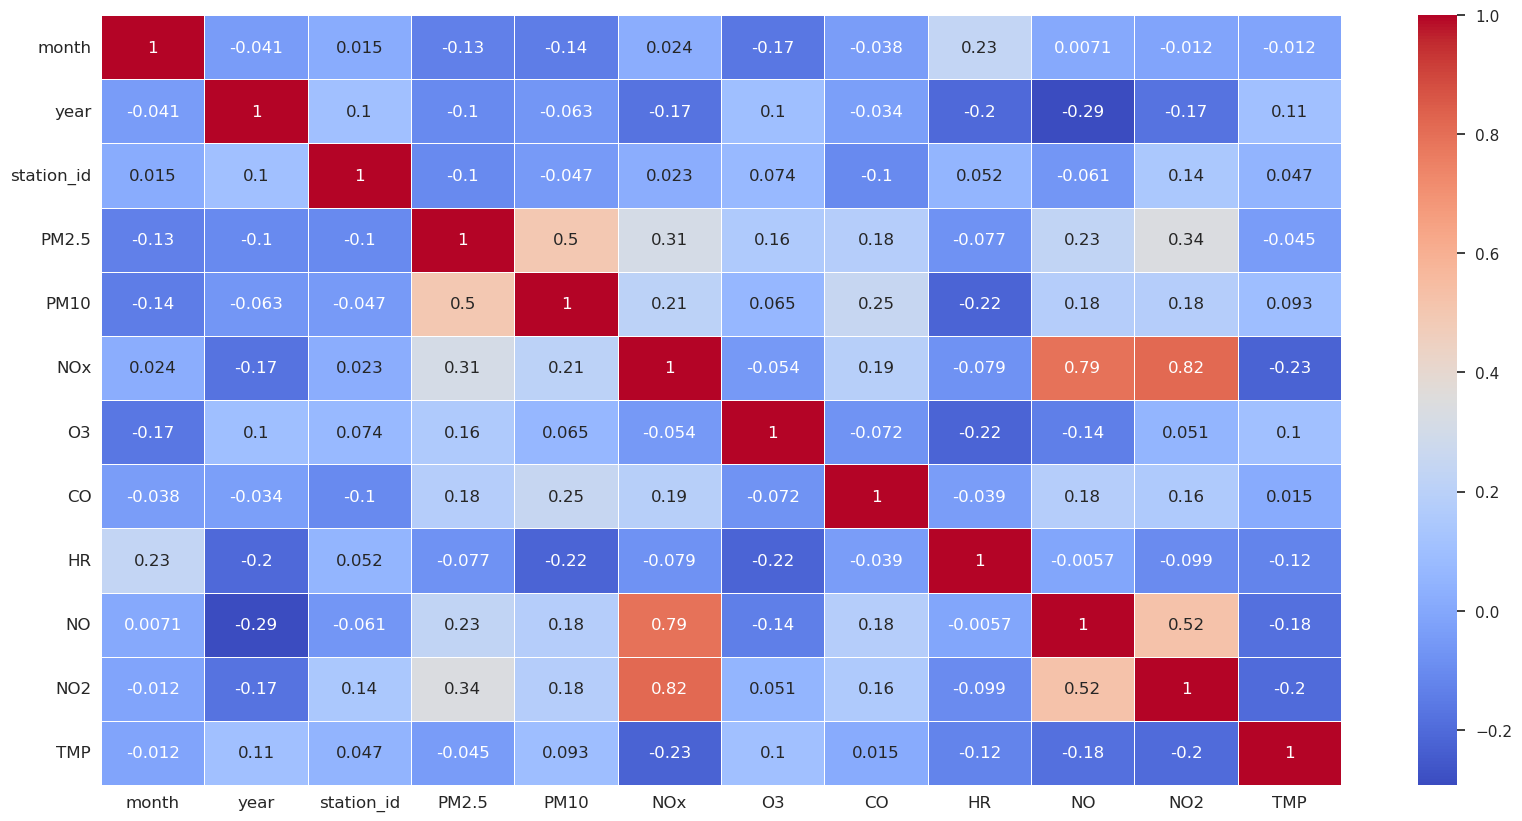

In [21]:
data_to_corr = daily_df.iloc[:,1:]
plt.gcf().set_size_inches(20, 10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.set(font_scale=1)
dataplot = sns.heatmap(data_to_corr.corr(), cmap="coolwarm", annot = True, linewidths=.5)

# Graph PM2.5 and PM10

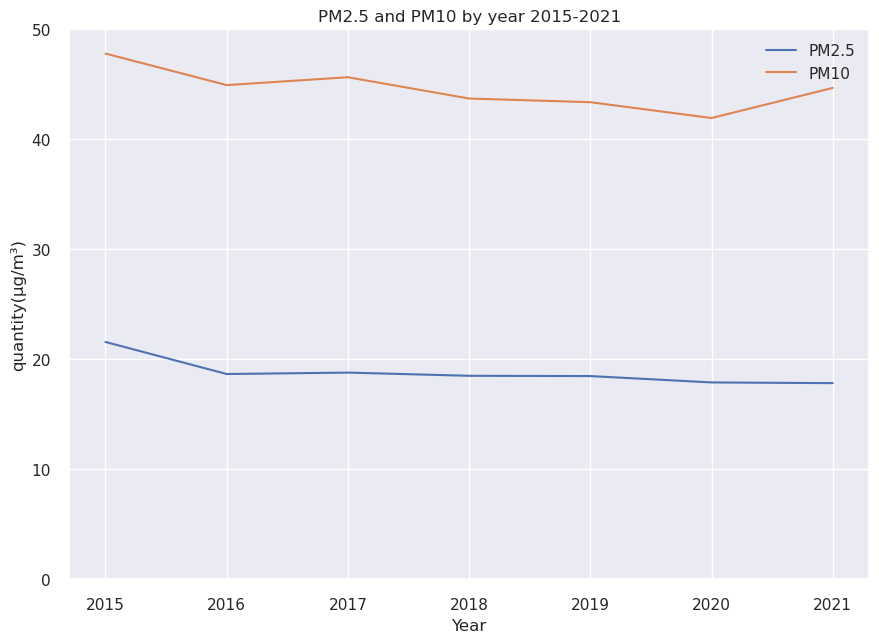

In [22]:
line_Graph = plt.figure()

ax = line_Graph.add_axes([0,0,1,1])
ax.set_title('PM2.5 and PM10 by year 2015-2021')
plt.xlabel('Year')
plt.ylabel('quantity(µg/m³)')
ax.plot(group_y["PM2.5"].mean(), label="PM2.5")
ax.plot(group_y["PM10"].mean(), label="PM10")
plt.ylim(0, 50)
ax.legend()

In [23]:
data = daily_df.copy()
data["Series"] = np.arange(1, len(data) + 1)
data_PM2_5 = data[["Series", "month", "year", "PM2.5"]]
data_PM10 = data[["Series", "month", "year", "PM10"]]
data

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP,Series
0,2015-01-02,1,2015,74,23.176346,95.715250,0.063575,0.018688,1.183263,44.274875,0.036966,0.026609,20.507292,1
1,2015-01-04,1,2015,74,15.794987,77.297125,0.038281,0.021169,0.837088,49.585542,0.021857,0.016424,18.225083,2
2,2015-01-05,1,2015,74,8.660900,57.438542,0.035275,0.027931,0.778861,44.201000,0.020107,0.015169,16.027417,3
3,2015-01-06,1,2015,74,22.810917,66.026583,0.053696,0.023617,0.943190,45.484708,0.034774,0.018922,18.552708,4
4,2015-01-07,1,2015,74,14.885212,72.031292,0.051143,0.024690,0.953216,51.053167,0.036871,0.014273,18.847958,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125818,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.009161,0.024762,21.660833,125819
125819,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.009161,0.023225,23.731250,125820
125820,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.009161,0.026500,22.751250,125821
125821,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.009161,0.023929,22.988333,125822


In [24]:
def predict(df, to_predict):
    
    train = df[df['year'] < 2021]
    test = df[df['year'] >=2021]

    s = setup(data = train, test_data = test, target = to_predict, fold_shuffle=False, data_split_shuffle=False,fold_strategy = 'timeseries', numeric_features = ['month','year', 'Series'], fold = 3, transform_target = True, session_id = 123)

    print(f"train shape:{train.shape} test shape:{test.shape}")
    
    best = compare_models(sort = 'MAE')

    future_dates = pd.date_range(start = '2022-01-01', end = '2023-12-31', freq = 'MS')
    future_df = pd.DataFrame()
    future_df['month'] = [i.month for i in future_dates]
    future_df['year'] = [i.year for i in future_dates]    
    future_df['Series'] = np.arange(df["Series"].max()+1,(df["Series"].max()+1+len(future_dates)))
    
    predictions_future = predict_model(best, data=future_df)
    return predictions_future

In [25]:
# predicted_data_PM2_5 = predict(data_PM2_5, "PM2.5")
# predicted_data_PM10 = predict(data_PM10, "PM10")

In [26]:
# g_by_y_m = predicted_data_PM2_5.groupby(["year","month"])

# line_Graph = plt.figure()

# ax = line_Graph.add_axes([0,0,1,1])
# ax.set_title('PM2.5 and PM10 by year 2015-2021')
# plt.xlabel('Month')
# plt.ylabel('quantity(µg/m³)')
# ax.plot(g_by_y_m["prediction_label"].mean().transpose()[2022], label="PM2.5")
# plt.ylim(0, 50)
# ax.legend()

# Concentration of Gas

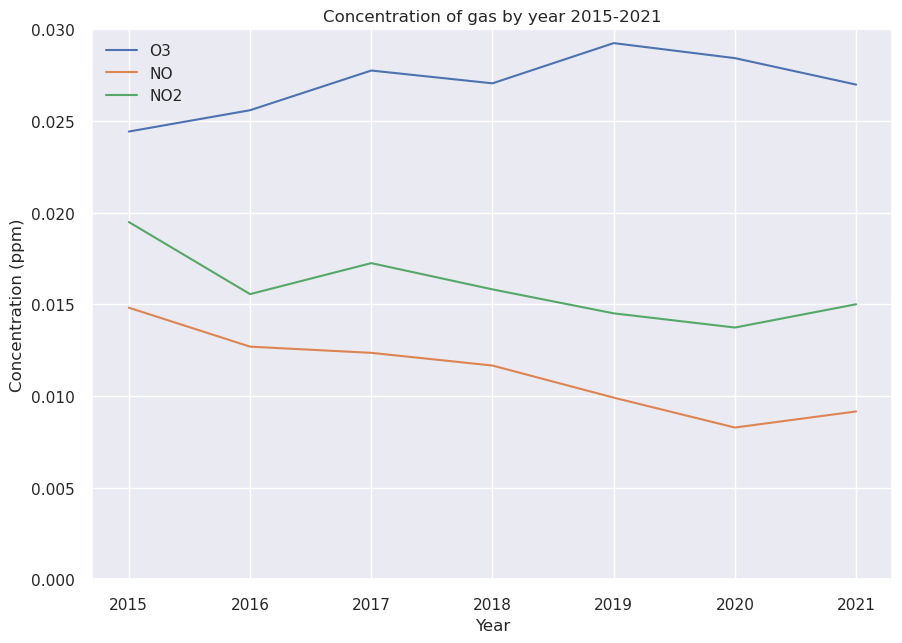

In [27]:
line_Graph = plt.figure()

ax = line_Graph.add_axes([0,0,1,1])
ax.set_title('Concentration of gas by year 2015-2021')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
ax.plot(group_y["O3"].mean(), label="O3")
# ax.plot(group_y["CO"].mean(), label="CO")
ax.plot(group_y["NO"].mean(), label="NO")
ax.plot(group_y["NO2"].mean(), label="NO2")
plt.ylim(0, 0.03)
ax.legend()

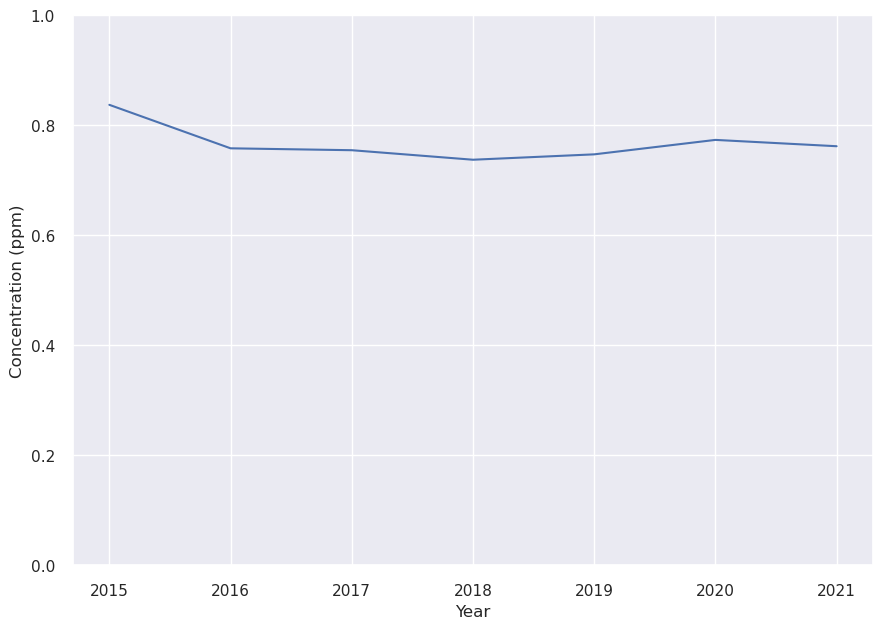

In [28]:
# fillna with average of that specific time
line_Graph = plt.figure()
ax = line_Graph.add_axes([0,0,1,1])
ax.plot(group_y["CO"].mean(), label="CO")
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.ylim(0, 1)
plt.show()

In [29]:
# p1_df = pd.DataFrame({"Average PM2.5": daily_df.groupby("year")["PM2.5"].mean()}).reset_index()
# p1_df
# p1_df.plot("year", "Average PM2.5", kind='bar', color="#337fff", width=0.5);
# plt.xlabel('Year')
# plt.ylabel('PM2.5 quantity(µg/m³)')
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# plt.legend()
# plt.xticks(rotation = 45)

# statistic by season

In [30]:
# month with avr
daily_df.groupby("month").mean()

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
month,,,,,,,,,,,
1,2018.448684,184.389224,20.075662,49.225923,0.029929,0.024136,0.891937,54.304409,0.012912,0.017875,16.060457
2,2018.343454,184.027508,20.167265,51.046574,0.028640,0.026222,0.857091,50.796175,0.012762,0.017358,17.694621
3,2018.284500,181.560978,20.599892,50.532883,0.026298,0.029171,0.788097,49.805227,0.010993,0.016384,19.265328
4,2018.325598,179.789008,22.315648,51.968003,0.024544,0.033223,0.756049,47.765928,0.010151,0.015684,20.610530
5,2018.306825,179.675676,21.824600,48.265776,0.023192,0.033320,0.730649,52.642064,0.009495,0.014888,21.638894
6,2018.269338,181.860153,16.928086,39.025010,0.022508,0.029145,0.702500,59.716206,0.009584,0.013944,21.194657
7,2018.230683,181.452934,17.372790,40.674730,0.023748,0.027864,0.707602,62.191278,0.010225,0.014416,20.520051
8,2018.133151,184.480215,16.188462,36.520758,0.023505,0.026988,0.678492,62.620471,0.010142,0.014163,20.717287
9,2018.117788,184.467593,16.015184,35.435306,0.024067,0.025661,0.707843,64.770230,0.010378,0.014449,20.126042


In [31]:
# In Mexico, hot season are 1, 2, 3, 4, 11, 12
hot_s = daily_df.groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean().to_frame().T.assign(season=["hot_season"]).set_index("season")
hot_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2018.300037,183.924629,20.394256,49.912459,0.028341,0.026569,0.831055,52.873389,0.01197,0.017179,17.98813


In [32]:
# In Mexico, wet season are 5, 6, 7, 8, 9, 10
wet_s = daily_df.groupby("month").mean()[4:10].mean().to_frame().T.assign(season=["wet_season"]).set_index("season")
wet_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
wet_season,2018.195485,182.899836,17.370057,39.855094,0.023834,0.027948,0.710878,60.545794,0.010199,0.014504,20.596309


In [33]:
# merge season
season = hot_s.append(wet_s)
season

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2018.300037,183.924629,20.394256,49.912459,0.028341,0.026569,0.831055,52.873389,0.011970,0.017179,17.988130
wet_season,2018.195485,182.899836,17.370057,39.855094,0.023834,0.027948,0.710878,60.545794,0.010199,0.014504,20.596309


### compare wet and hot season

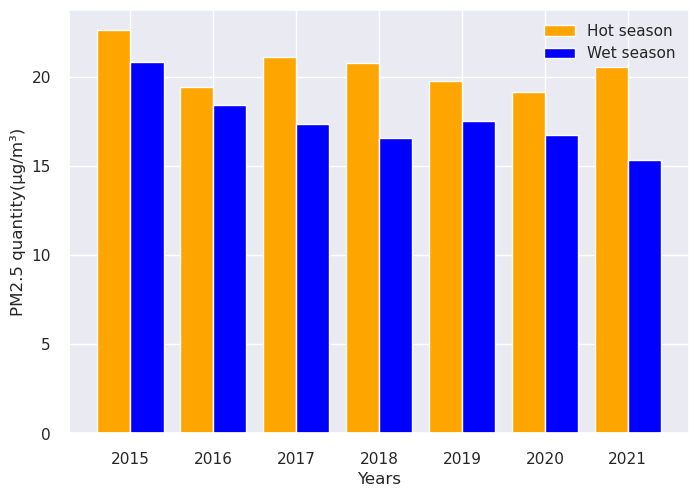

In [34]:
hot_s_list, wet_s_list = [], []
year = list(range(2015, 2022))
x = np.arange(7)
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM2.5"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM2.5"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM2.5 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

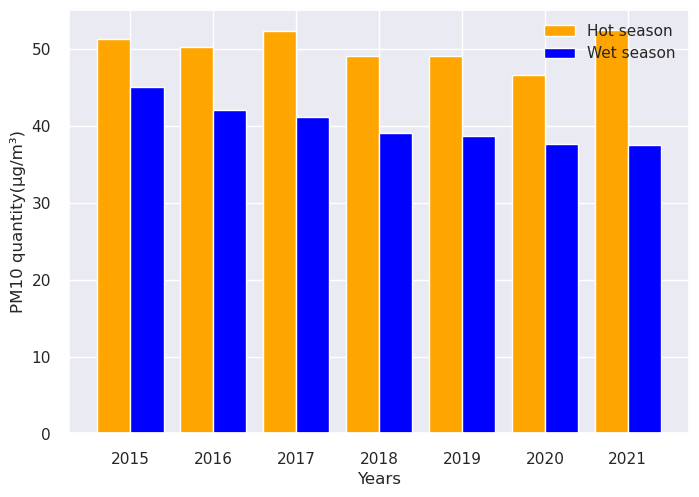

In [35]:
hot_s_list, wet_s_list = [], []
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM10"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM10"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM10 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

# hourly_df

In [36]:
# hourly_df.head()

In [37]:
# for y in daily_df["year"].unique()[3:]:
#     value = (mean_y[y])
#     print(y)
#     (daily_df[daily_df["year"]==y]["PM2.5"].fillna(value, inplace = True))


In [38]:
daily_df[daily_df["year"] == 2010]["PM10"]

Series([], Name: PM10, dtype: float64)

In [39]:
# hourly_df.drop_duplicates(["datetime", "station_id"])
# hourly_df.sort_values("datetime")

# rsinaica_df

In [40]:
rsinaica_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         341 non-null    int64  
 1   station_name       341 non-null    object 
 2   station_code       341 non-null    object 
 3   network_id         341 non-null    int64  
 4   network_name       334 non-null    object 
 5   network_code       340 non-null    object 
 6   street             187 non-null    object 
 7   ext                154 non-null    object 
 8   interior           74 non-null     object 
 9   colonia            186 non-null    object 
 10  zip                143 non-null    object 
 11  state_code         299 non-null    float64
 12  municipio_code     299 non-null    float64
 13  year_started       138 non-null    float64
 14  altitude           320 non-null    float64
 15  address            138 non-null    object 
 16  date_validated     20 non-

In [41]:
rsinaica_df

#network_name is city

,station_id,station_name,station_code,network_id,network_name,network_code,street,ext,interior,colonia,...,date_validated2,passed_validation,video,lat,lon,date_started,timezone,street_view,video_interior,color
0,397,"CENICA 1, UAM Iztapalapa",CEN,144,NaN,ESTSP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2002-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
1,344,C. Salud Tlaxcoapán,TCP,127,NaN,TCP,NaN,NaN,NaN,NaN,...,NaN,NaN,Array,20.091472,-99.228417,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
2,365,Costa Baja,UM,140,NaN,LAP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010-03-14,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
3,393,Unidad Móvil de Hidalgo,UMHI,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-24,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
4,394,Unidad Móvil Iztapalapa,UMIZ,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-21,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,239,IMSS Zac,IMSS,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.775258,-102.566667,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
337,295,Col. Minera,MIN,118,Zacatecas,ZAC,mina sirena,132,NaN,MINERA,...,NaN,NaN,NaN,22.770455,-102.585126,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
338,238,ZigZag,ZZZ,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.762161,-102.578906,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
339,135,Tecnológico de Zacatepec,TEC,70,Zacatepec,ZAC,Plan de Ayala,27,NaN,Zacatepec de Hidalgo,...,2014-12-31,0.0,https://www.youtube.com/watch?v=J73gPYviTRc,18.654444,-99.183333,2013-12-31,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others


In [42]:
rsinaica_df.drop(rsinaica_df[rsinaica_df["network_name"].isna()].index, inplace = True)

In [43]:
# # due to only 7 nan value in network_name we will fill it by ourself
# # create list of city to fill in nan first
# list_miss_city = ["Mexico City", "Tlaxcoapán", "La Paz", "Unknown", "Mexico City", "Tecamachalco", "Toluca"]
# for index in np.arange(0,7):
#     rsinaica_df.loc[index, "network_name"] = list_miss_city[index]
# rsinaica_df.head(7)

make new dataframe caontain station_id and network_name(city)

In [44]:
data = {"station_id":rsinaica_df["station_id"],
        "network_name":rsinaica_df["network_name"],
       "longitude":rsinaica_df["lon"],
        "latitude":rsinaica_df["lat"]}
new_df = pd.DataFrame(data)
new_df

,station_id,network_name,longitude,latitude
7,356,Abasolo,-101.198056,20.425278
8,353,Acámbaro,-101.208611,20.590833
9,184,Agua Prieta,-109.535639,31.311944
10,31,Aguascalientes,-102.320803,21.873311
11,33,Aguascalientes,-102.295825,21.883781
...,...,...,...,...
336,239,Zacatecas,-102.566667,22.775258
337,295,Zacatecas,-102.585126,22.770455
338,238,Zacatecas,-102.578906,22.762161
339,135,Zacatepec,-99.183333,18.654444


#  prepare data for คำนวณ อับดับเมือง
merge new_df and daily_df

In [45]:
daily_station = pd.merge(daily_df, new_df,on="station_id")

In [46]:
daily_station.sort_values(by=["year", "month"], inplace = True)
daily_station["station_id"].unique()

array([ 74,  77,  78,  82,  85,  92,  93, 102, 103, 106, 109, 123, 125,
       126, 128, 129, 136, 137, 139, 140, 141, 143, 145, 146, 147, 160,
       161, 162, 163, 234, 241, 242, 244, 245, 251, 256, 258, 260, 262,
       263, 266, 268, 269, 271,  33,  56, 142, 148,  32,  87, 297,  59,
       134, 301,  68, 292, 302,  53,  60, 291, 306,  84,  70,  72,  75,
       304, 305,  73, 220, 352, 358, 356, 359, 424, 425, 388, 426, 293])

In [47]:
daily_station["network_name"].unique()

array(['León', 'Salamanca', 'Atitalaquia', 'Huichapan', 'Pachuca',
       'Guadalajara', 'Toluca', 'Morelia', 'Tepic', 'Monterrey', 'Oaxaca',
       'Puebla', 'Minatitlán', 'Valle de México', 'Aguascalientes',
       'Torreón', 'Tepeji', 'Durango', 'Cuernavaca', 'Celaya',
       'Tulancingo', 'Chihuahua', 'Poza Rica', 'Piedras Negras',
       'Tepeapulco', 'Irapuato', 'Saltillo', 'Monclova', 'Tlaxcala',
       'San Miguel de Allende', 'San Luis de la Paz', 'Abasolo',
       'Guanajuato', 'Guerrero'], dtype=object)

Ranking of townn

In [48]:
group_town = daily_station.groupby("network_name")
group_town.describe()["PM2.5"]

,count,mean,std,min,25%,50%,75%,max
network_name,,,,,,,,
Abasolo,1519.0,13.286535,7.251586,1.000000,7.969007,12.039687,17.133679,47.826087
Aguascalientes,1276.0,7.972564,9.155102,0.004823,0.034652,1.976933,17.905068,48.133273
Atitalaquia,2065.0,20.520573,7.200085,0.065438,17.905068,18.509422,21.583053,47.741354
Celaya,2498.0,17.415860,7.428054,0.000500,11.995729,17.006947,21.381607,47.961176
Chihuahua,1717.0,17.068611,7.114706,2.900000,11.100000,18.080000,21.991667,46.881250
Cuernavaca,1638.0,19.256283,8.781810,1.178589,12.668742,18.364322,24.284099,47.731920
Durango,1696.0,15.165077,7.407529,0.352007,9.900889,13.952806,18.484187,46.890250
Guadalajara,8407.0,20.100178,6.509217,1.135260,17.840156,18.669428,21.583053,48.136283
Guanajuato,1620.0,11.793465,5.123974,1.500000,8.083926,11.292857,14.674041,45.920819


Text(0.5, 1.0, 'Ranking of City')

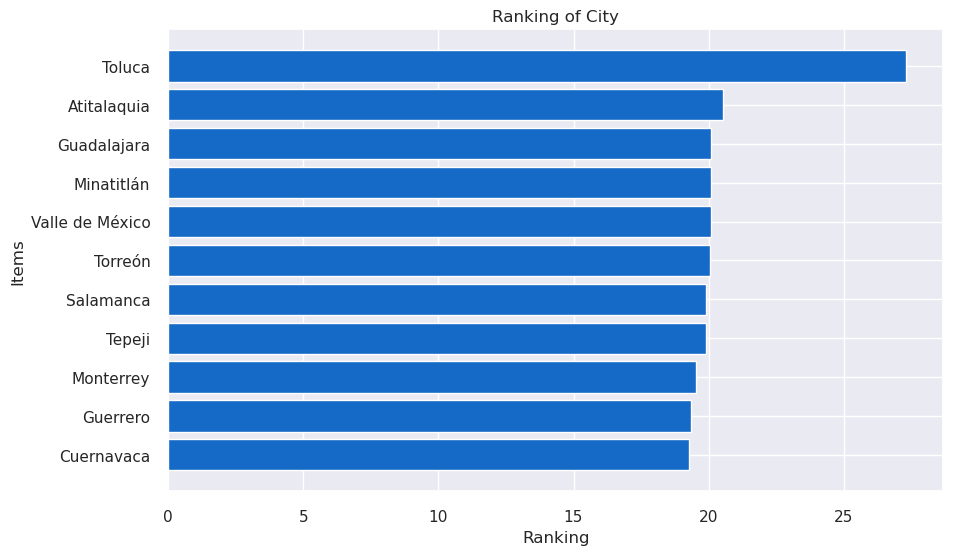

In [49]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

ranking = group_town["PM2.5"].mean().sort_values(ascending=False)[0:11]
ranking.index
# Plot the horizontal bar chart
plt.barh(ranking.index[::-1], ranking[::-1], color='#1569C7')

# Customize labels and title
plt.xlabel('Ranking')
plt.ylabel('Items')
plt.title('Ranking of City')

# # Display the chart
# plt.show()

In [50]:
categories = {"Petrolium":["Salamanca", "Monterrey", "Poza Rica"],
              "Agricultural":["Tepic", "Aguascalientes", "Oaxaca", "Torreón", "Chihuahua", "Irapuato", "Guerrero"],
              "Mining":["Pachuca", "Aguascalientes", "Chihuahua", "Durango"],
              "Automotive":["Toluca", "Puebla", "Celaya", "Tulancingo", "Piedras Negras", "Tepeapulco", "Irapuato", "Satillo", "Monclova", "Tlaxcala", "San Miguel de Allende", "San Luis de la Paz", "Abasolo", "Guanajuato"],
              "Tourism":["Morellia"],
              "Textile":["León", "Toluca", "Aguascalientes", "Tulancingo", "Tlaxcala"]
             }

def get_data(cate):
    result_df = pd.DataFrame()

    for city in categories[cate]:
        result_df = pd.concat([result_df, daily_station[daily_station["network_name"] == city]], ignore_index=True)

    return result_df
industries = [[],[],[],[],[],[]]
i = 0
for cate in categories:
    industries[i] = get_data(cate)
    i+=1

In [51]:
group_station = daily_station.groupby("station_id") 
group_station.mean()["PM2.5"]

station_id
32      9.865070
33      6.385477
53     17.068611
56     20.042247
59     17.300856
         ...    
359    11.793465
388    17.815658
424    18.216423
425    19.292229
426    13.768536
Name: PM2.5, Length: 78, dtype: float64

In [52]:
station_df = pd.DataFrame({
    "PM2.5 mean":group_station.mean()["PM2.5"],
    "longitude":group_station.max()["longitude"],
    "latitude":group_station.max()["latitude"]
})
station_df.reset_index(inplace=True)
station_df

,station_id,PM2.5 mean,longitude,latitude
0,32,9.865070,-102.288431,21.846392
1,33,6.385477,-102.295825,21.883781
2,53,17.068611,-106.038867,28.632775
3,56,20.042247,-103.395806,25.522694
4,59,17.300856,-104.611361,24.051556
...,...,...,...,...
73,359,11.793465,-101.257361,21.017583
74,388,17.815658,-101.195000,19.701389
75,424,18.216423,-99.994167,25.600556
76,425,19.292229,-100.309722,25.730000


In [53]:
geometry = [Point(xy) for xy in zip(station_df['longitude'], station_df['latitude'])]
mexico_point = gpd.GeoDataFrame(station_df, geometry=geometry)
mexico_point.head()

,station_id,PM2.5 mean,longitude,latitude,geometry
0,32,9.865070,-102.288431,21.846392,POINT (-102.28843 21.84639)
1,33,6.385477,-102.295825,21.883781,POINT (-102.29582 21.88378)
2,53,17.068611,-106.038867,28.632775,POINT (-106.03887 28.63277)
3,56,20.042247,-103.395806,25.522694,POINT (-103.39581 25.52269)
4,59,17.300856,-104.611361,24.051556,POINT (-104.61136 24.05156)


In [54]:
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB values
custom_cmap = LinearSegmentedColormap.from_list('green_yellow_red', colors, N=256)


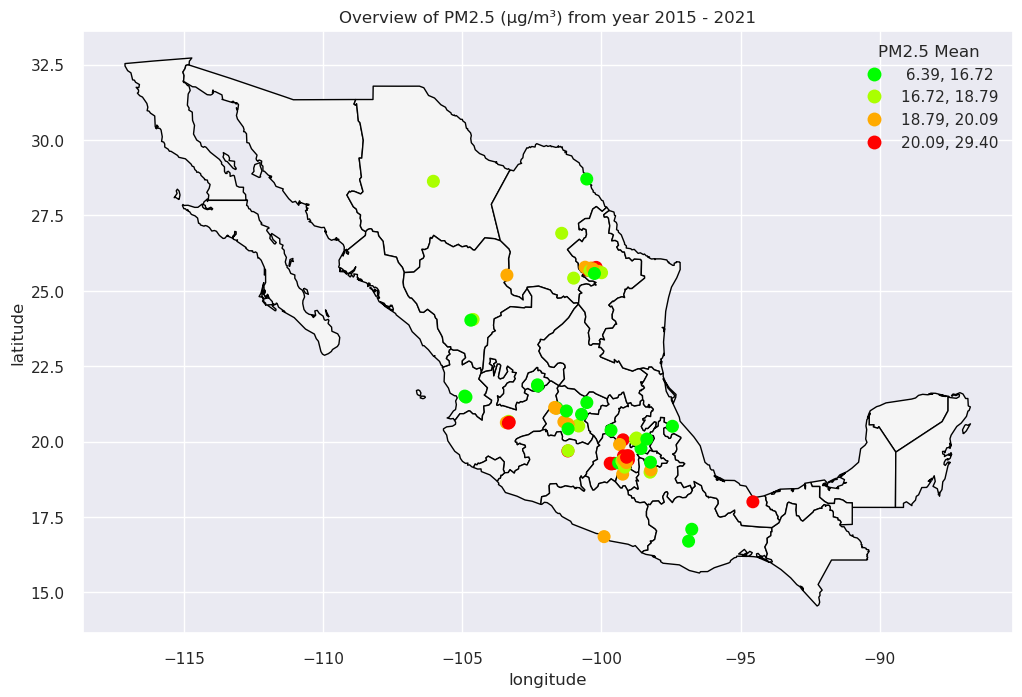

In [55]:
mexico_map = gpd.read_file("map/Mexico_States.shp")
# mexico_point = mexico_point.to_crs(mexico_map.crs)
# print(mexico_map.crs)
mexico_point.crs = mexico_map.crs
mexico_point = mexico_point.to_crs(mexico_map.crs)
points_in_polygons = gpd.sjoin(mexico_point, mexico_map, predicate='within')
ax = mexico_map.plot(figsize=(12, 10), color="whitesmoke", edgecolor="black")
points_in_polygons.plot(ax = ax, column = "PM2.5 mean",figsize=(12,10), legend=True ,scheme = "quantiles",k=4,cmap=custom_cmap, markersize=70)
legend = ax.get_legend()
legend.set_title("PM2.5 Mean")
plt.title("Overview of PM2.5 (µg/m³) from year 2015 - 2021")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()